In [1]:
from datasets import load_dataset, load_metric
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import Sequential, layers, regularizers
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
import keras
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
import tensorflow.keras.optimizers 
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import keras.utils
import matplotlib as mpl




In [2]:
data_dir = r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane"

In [3]:
# data_dir=r"C:\Users\Jan\SGH\magisterka\test_model2\2750"

In [4]:
batch_size = 16
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=23,
  image_size= (img_height, img_width),
  batch_size=batch_size)


val_ds =  tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=23,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


In [5]:
# for images, labels in train_ds.take(1):
#     print("Labels from a batch of train_ds:")
#     print(labels.numpy())

# # Do the same for the validation dataset
# for images, labels in val_ds.take(1):
#     print("\nLabels from a batch of val_ds:")
#     print(labels.numpy())

In [6]:
# # Ekstrakcja jednego batcha danych
# for images, labels in val_ds.take(1):
#     # Wybór pierwszego obrazu z batcha
#     example_image = images[0]

#     # Konwersja tensora na tablicę NumPy i wydrukowanie wszystkich wartości
#     numpy_image = example_image.numpy()
#     print("Wszystkie wartości tensora dla jednego obrazu:")
#     print(numpy_image)


In [7]:
# image_batch, labels_batch = next(iter(normalizead_ds))
# first_image = image_batch[0]
# first_image

In [8]:
class_names = np.array(train_ds.class_names)
class_names

array(['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
       'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps',
       'ulcerative-colitis'], dtype='<U22')

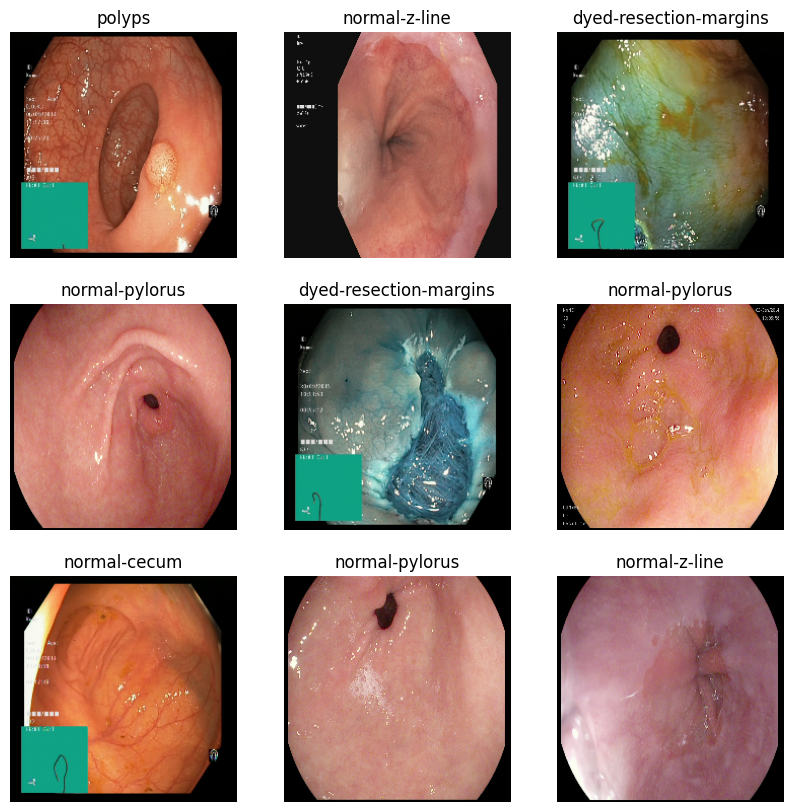

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

In [10]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
#     layers.RandomContrast(0.9, 1.1),
    layers.RandomZoom(
        height_factor=0.2, width_factor=0.2
    ),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

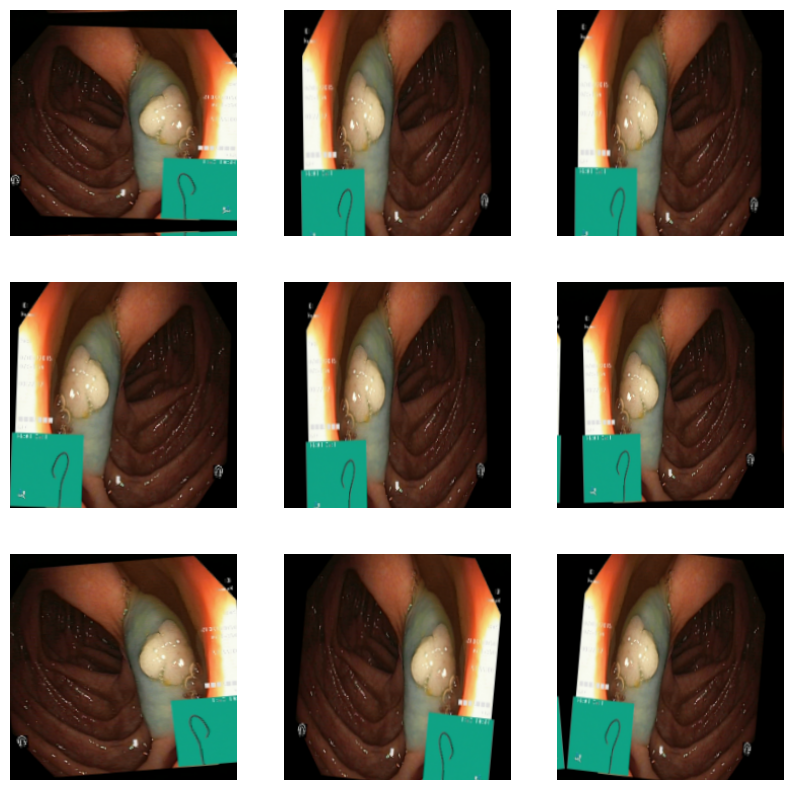

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [12]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]

# print(np.min(first_image), np.max(first_image))

#### Augmentacja danych zbioru uczącego

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#### Normalizacja wartości piksela z przedziału [0,255] do [0,1]

In [14]:
rescale = keras.Sequential(
    [
        layers.Rescaling(1.0 / 255), 
    ],
    name = "rescale"
)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3),  name = "Top_Conv_Layer"),
    rescale,
    # Convolutional layers with batch normalization and max pooling
    tf.keras.layers.Conv2D(32, (3, 3), activation=None, input_shape=(224, 224, 3)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(1024, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the output and add Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),

    # Output layer with 8 nodes for classification
    tf.keras.layers.Dense(8, activation='softmax')
])

In [16]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# model = Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     # Pierwsza warstwa konwolucyjna
#     Conv2D(32, (3, 3), activation='relu', input_shape=(576, 576, 3)),
# #     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     # Druga warstwa konwolucyjna
#     Conv2D(64, (3, 3), activation='relu'),
# #     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     # Trzecia warstwa konwolucyjna
#     Conv2D(128, (3, 3), activation='relu'),
# #     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     # Czwarta warstwa konwolucyjna
#     Conv2D(256, (3, 3), activation='relu'),
# #     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     # Spłaszczenie i pełno-połączone warstwy
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(256, activation='relu'),
#     Dropout(0.2),

#     # Wyjściowa warstwa Dense
#     # Liczba neuronów i funkcja aktywacji zależą od problemu
#     Dense(len(class_names), activation='relu')  # Dla klasyfikacji 10 klas
# ])

In [17]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])
# model.summary()

In [18]:
epochs = 30

In [19]:
val_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [20]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [21]:
history = model.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop]
)

Epoch 1/30
400/400 [==============================] - 24s 42ms/step - loss: 1.0263 - accuracy: 0.5711 - val_loss: 1.4489 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 2/30
400/400 [==============================] - 14s 33ms/step - loss: 0.8640 - accuracy: 0.6169 - val_loss: 1.7912 - val_accuracy: 0.4450 - lr: 0.0010
Epoch 3/30
400/400 [==============================] - 13s 33ms/step - loss: 0.7886 - accuracy: 0.6564 - val_loss: 0.7521 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 4/30
400/400 [==============================] - 13s 33ms/step - loss: 0.7326 - accuracy: 0.6781 - val_loss: 1.1611 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 5/30
400/400 [==============================] - 14s 33ms/step - loss: 0.7105 - accuracy: 0.6956 - val_loss: 1.7951 - val_accuracy: 0.4956 - lr: 0.0010
Epoch 6/30
400/400 [==============================] - 13s 33ms/step - loss: 0.6777 - accuracy: 0.7105 - val_loss: 0.8652 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 7/30
400/400 [==============================] - 13s 

In [22]:
# #Define Some Functions :

# last_conv_layer_name = "Top_Conv_Layer"

# def get_img_array(img_path, size = (224 , 224)):
#     img = keras.utils.load_img(img_path, target_size=size)
#     array = keras.utils.img_to_array(img)
#     array = np.expand_dims(array, axis=0)
#     return array



# def make_gradcam_heatmap(img_array, model, last_conv_layer_name = last_conv_layer_name, pred_index=None):
#     # First, we create a model that maps the input image to the activations
#     # of the last conv layer as well as the output predictions
#     grad_model = keras.models.Model(
#         model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     # This is the gradient of the output neuron (top predicted or chosen)
#     # with regard to the output feature map of the last conv layer
#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     # This is a vector where each entry is the mean intensity of the gradient
#     # over a specific feature map channel
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the top predicted class
#     # then sum all the channels to obtain the heatmap class activation
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     # For visualization purpose, we will also normalize the heatmap between 0 & 1
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
#     # Load the original image
#     img = keras.utils.load_img(img_path)
#     img = keras.utils.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = mpl.colormaps["jet"]

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = keras.utils.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = keras.utils.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = keras.utils.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     if view :
#         display(Image(cam_path))
     
# def decode_predictions(preds):
#     classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
#     prediction = classes[np.argmax(preds)]
#     return prediction



# def make_prediction (img_path , model, last_conv_layer_name, campath = "cam.jpeg" , view = False):
#     img = get_img_array(img_path = img_path)
#     img_array = get_img_array(img_path, size=(224 , 224))
#     preds = Model_1.predict(img_array)
#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
#     save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
#     return [campath , decode_predictions(preds)]

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescale (Sequential)        (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 222, 222, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      1

In [24]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

def get_predictions_and_labels(model, dataset):
    all_predictions = []
    all_labels = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        all_predictions.extend(predicted_labels)
        all_labels.extend(labels.numpy())

    return all_predictions, all_labels

# Uzyskaj przewidywania i etykiety dla zbiorów treningowego i walidacyjnego
train_predictions, train_labels = get_predictions_and_labels(model, train_ds)
val_predictions, val_labels = get_predictions_and_labels(model, val_ds)

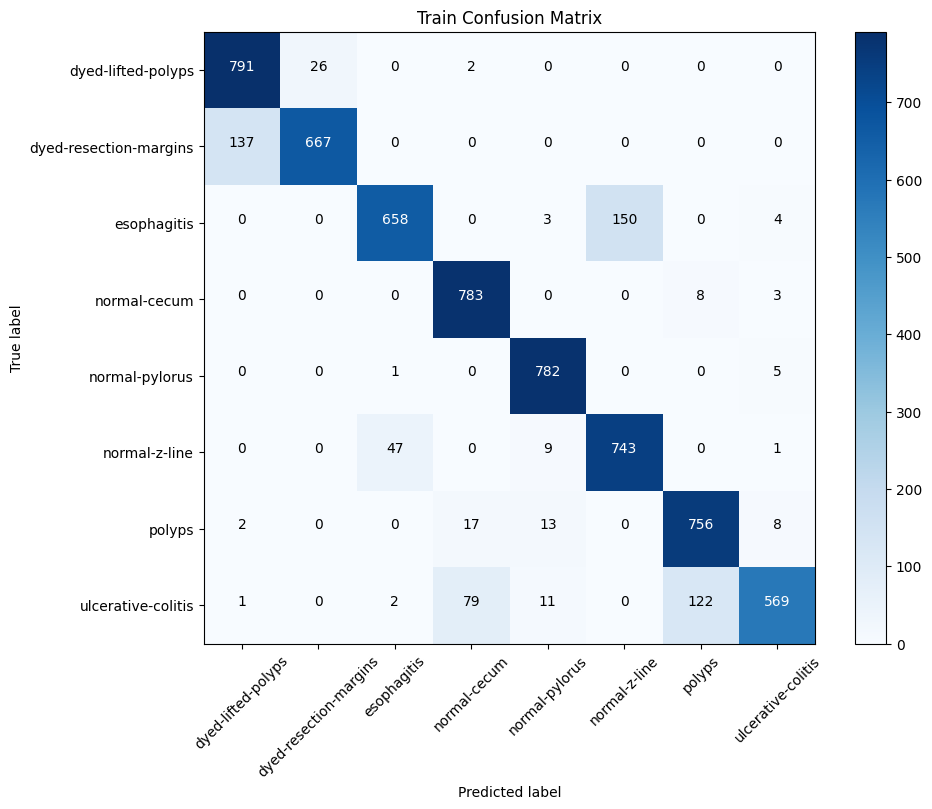

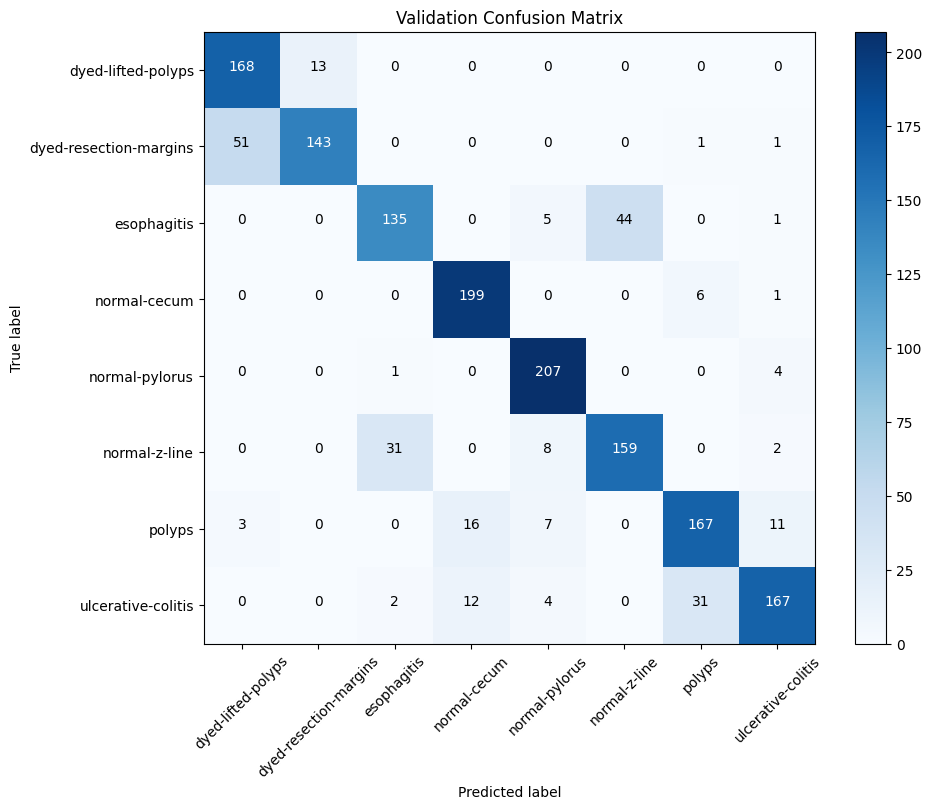

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Tworzenie i wyświetlanie macierzy pomyłek
cm_train = confusion_matrix(np.argmax(train_labels, axis=1), train_predictions)
cm_val = confusion_matrix(np.argmax(val_labels, axis=1), val_predictions)
plot_confusion_matrix(cm_train, class_names, 'Train Confusion Matrix')
plot_confusion_matrix(cm_val, class_names, 'Validation Confusion Matrix')


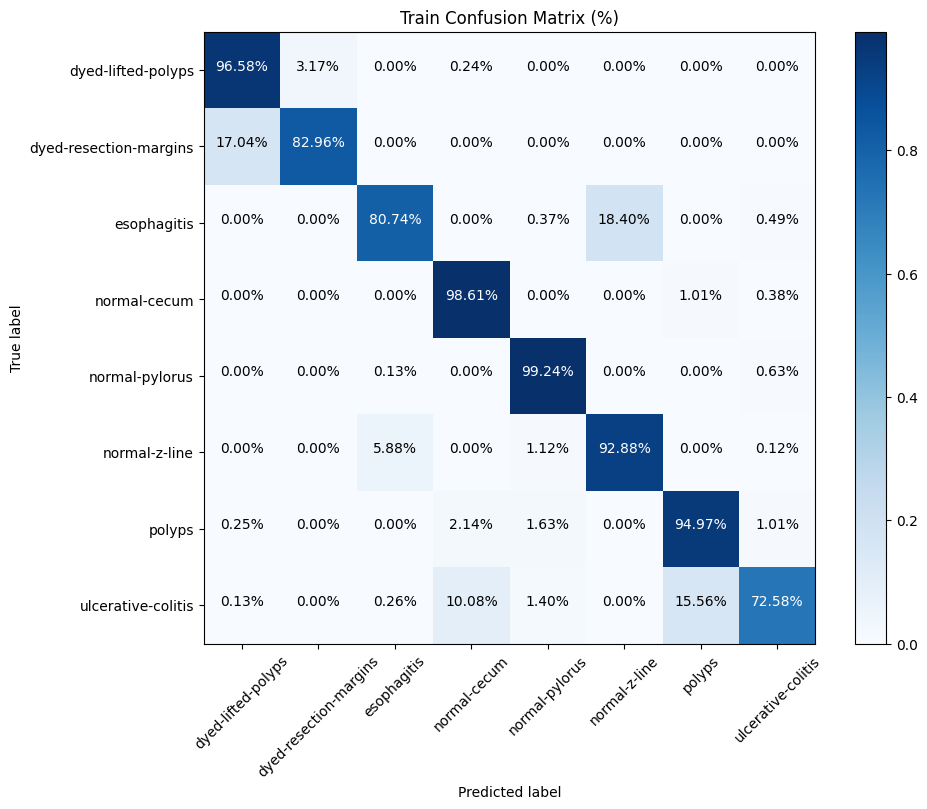

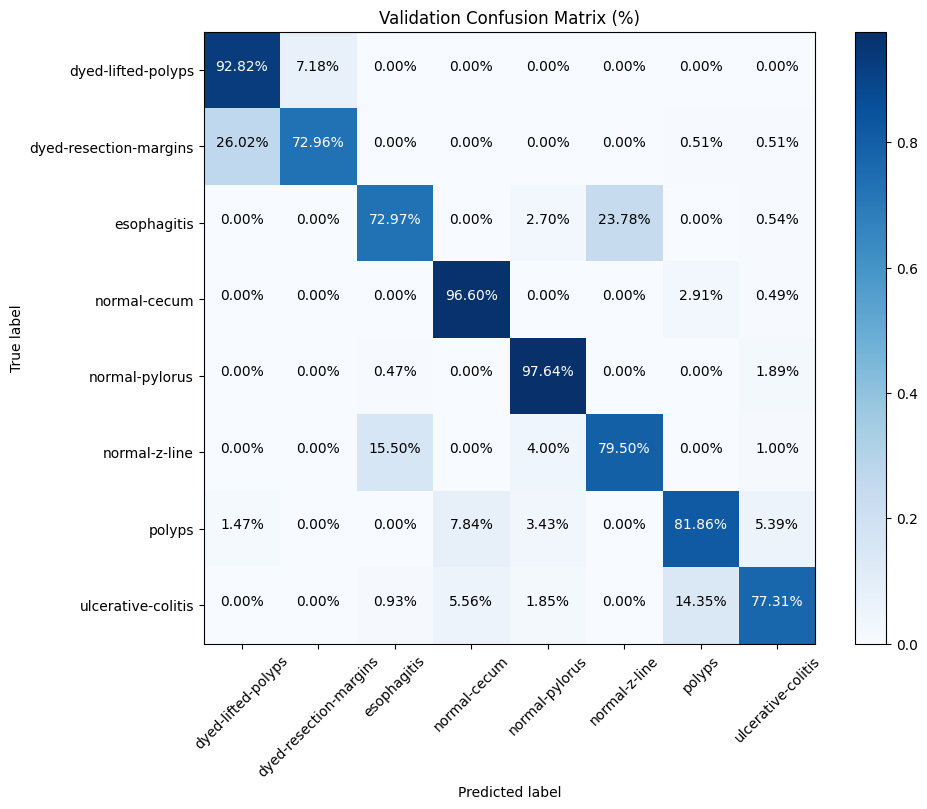

In [26]:
def plot_confusion_matrix_percent(cm, classes, title='Confusion Matrix (%)', figsize=(10, 8)):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=figsize)
    plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm_percent.max() / 2.
    for i, j in itertools.product(range(cm_percent.shape[0]), range(cm_percent.shape[1])):
        plt.text(j, i, f"{cm_percent[i, j]:.2%}",
                 horizontalalignment="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# Wyświetlanie procentowej macierzy pomyłek
plot_confusion_matrix_percent(cm_train, class_names, 'Train Confusion Matrix (%)')
plot_confusion_matrix_percent(cm_val, class_names, 'Validation Confusion Matrix (%)')

In [65]:
#Define Some Functions :

last_conv_layer_name = "conv2d_5"

def get_img_array(img_path, size = (224 , 224)):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = model , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))

In [66]:
def decode_predictions(preds):
    classes = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
       'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps',
       'ulcerative-colitis']
    prediction = classes[np.argmax(preds)]
    return prediction

In [67]:
def make_prediction (img_path , model = model , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]

In [71]:
!pip install scikit-image

     --------------------------------------- 12.1/12.1 MB 27.3 MB/s eta 0:00:00
     ------------------------------------- 313.2/313.2 kB 18.9 MB/s eta 0:00:00
     ------------------------------------- 178.9/178.9 kB 10.5 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 33.2 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 30.4 MB/s eta 0:00:00


In [72]:
from skimage.io import imread, imsave

In [77]:
test_img = imread(campath)

In [79]:
test_img

array([[[ 2,  2, 40],
        [ 2,  2, 40],
        [ 2,  2, 40],
        ...,
        [ 1,  1, 35],
        [ 1,  1, 35],
        [ 1,  1, 35]],

       [[ 2,  2, 40],
        [ 2,  2, 40],
        [ 2,  2, 40],
        ...,
        [ 1,  1, 35],
        [ 1,  1, 35],
        [ 1,  1, 35]],

       [[ 2,  2, 40],
        [ 2,  2, 40],
        [ 2,  2, 40],
        ...,
        [ 1,  1, 35],
        [ 1,  1, 35],
        [ 1,  1, 35]],

       ...,

       [[ 0,  0, 34],
        [ 0,  0, 34],
        [ 0,  0, 34],
        ...,
        [ 0,  0, 30],
        [ 0,  0, 30],
        [ 0,  0, 30]],

       [[ 0,  0, 34],
        [ 0,  0, 34],
        [ 0,  0, 34],
        ...,
        [ 0,  0, 30],
        [ 0,  0, 30],
        [ 0,  0, 30]],

       [[ 0,  0, 34],
        [ 0,  0, 34],
        [ 0,  0, 34],
        ...,
        [ 0,  0, 30],
        [ 0,  0, 30],
        [ 0,  0, 30]]], dtype=uint8)

In [76]:
campath

'123.jpeg'

polyps


(-0.5, 719.5, 575.5, -0.5)

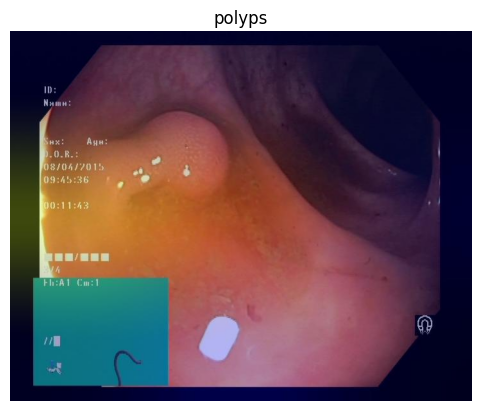

In [80]:
campath , prediction = make_prediction(r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane\polyps/0b4f0370-b25b-4e6a-a7ac-b09097bfecc3.jpg" , campath="123.jpeg" , view = False)
print(prediction)
test_img = imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

In [ ]:
print(model.layers[-1].activation)